# Climate Risk Assessment


## Preparations


Since I used a virtual environment, please use this kernel for reproduibility purposes...

In [12]:
import importlib
import subprocess
import sys

def install_packages(packages):
    for package in packages:
        try:
            importlib.import_module(package)
            print(f"{package} is already installed!")
        except ImportError:
            print(f"{package} is not installed, installing now...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} has been installed successfully!")


In [13]:
# Packages we used for this study
packages = ['numpy', 'pandas', 'matplotlib', 'intake', 'datetime', 'plotly', 'intake-esm', 'pathlib', 'requests',
           'aiohttp', 's3fs', 'xarray', 'fsspec', 'warnings', 'dask' , 'cartopy', 'netcdf4', 'MetPy','seaborn']

# Call the function to install all packages from the 
install_packages(packages)

numpy is already installed!
pandas is already installed!
matplotlib is already installed!
intake is already installed!
datetime is already installed!
plotly is already installed!
intake-esm is not installed, installing now...
intake-esm has been installed successfully!
pathlib is already installed!
requests is already installed!
aiohttp is already installed!
s3fs is already installed!
xarray is already installed!
fsspec is already installed!
warnings is already installed!
dask is already installed!
cartopy is already installed!
netcdf4 is not installed, installing now...
netcdf4 has been installed successfully!
MetPy is not installed, installing now...
MetPy has been installed successfully!
seaborn is already installed!


In [1]:
# import all packages from the same kernel we used (ensures reproducibility)
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import xarray as xr
import cartopy.crs as ccrs
import seaborn as sns

import intake
import requests
import aiohttp
import fsspec
import s3fs
import warnings

from cartopy.feature import COASTLINE
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

from dask.diagnostics import ProgressBar
from pathlib import Path
from datetime import time
from scipy.stats import linregress
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Data Download

Since the dataset is huge, we can not provide it on Github but you can download it (huge data set!)

# Preprocess the Data

In the next cache we define all functions we need to estimate wet-bulb temperture.

In [15]:
df_1 = xr.open_dataset("../data-raw/historic_010.nc", engine="netcdf4")
df_2 = xr.open_dataset("../data-raw/historic_1020.nc", engine="netcdf4")
df_3 = xr.open_dataset("../data-raw/historic_2030.nc", engine="netcdf4")
df_4 = xr.open_dataset("../data-raw/historic_3040.nc", engine="netcdf4")
df_5 = xr.open_dataset("../data-raw/historic_4050.nc", engine="netcdf4")
# Concatenate along 'member_id'
df_historic = xr.concat([df_1, df_2, df_3, df_4, df_5], dim='member_id')

df_1 = xr.open_dataset("../data-raw/future_010.nc", engine="netcdf4")
df_2 = xr.open_dataset("../data-raw/future_1020.nc", engine="netcdf4")
df_3 = xr.open_dataset("../data-raw/future_2030.nc", engine="netcdf4")
df_4 = xr.open_dataset("../data-raw/future_3040.nc", engine="netcdf4")
df_5 = xr.open_dataset("../data-raw/future_4050.nc", engine="netcdf4")
# Concatenate along 'member_id'
df_future = xr.concat([df_1, df_2, df_3, df_4, df_5], dim='member_id')

In [16]:
# FUNCTION: Calculate saturation vapor pressure (hPa) from temperature (°C) using Magnus Formula
def saturation_vapor_pressure(T_C):
    return 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))

# FUNCTION: Calculate vapor pressure (hPa) from specific humidity (kg/kg and pressure (Pa)
def actual_vapor_pressure(Q, P):
    return (Q * P) / (0.622 + 0.378 * Q) / 100  # divide by 100 to convert Pa to hPa

# FUNCTION: Calculate relative humidity (%) from specific humidity (Q in kg/kg), temperature (T_C in °C), and pressure (P in Pa)
def relative_humidity(Q, T_C, P):
    e_s = saturation_vapor_pressure(T_C)  # in hPa
    e = actual_vapor_pressure(Q, P)       # in hPa
    return (e / e_s) * 100                # multiply by 100 to convert in percent

# FUNCTION: Approximate wet-bulb temperature (°C) using Stull's formula
def wet_bulb_temperature(T, RH):
    return (T * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
            + np.arctan(T + RH)
            - np.arctan(RH - 1.676331)
            + 0.00391838 * RH**1.5 * np.arctan(0.023101 * RH)
            - 4.686035)

In [17]:
# Convert temperature from K to °C 
T_hist = df_historic['TREFHTMX'] - 273.15  
T_fut = df_future['TREFHTMX'] - 273.15  
# Convert specific humidity from g/kg to kg/kg 
Q_hist = df_historic['Q'] * 1000
Q_fut = df_future['Q'] * 1000
# Convert pressure from Pa to hPa 
P_hist = df_historic['PS'] / 100
P_fut = df_future['PS'] / 100

# FUNCTION CALL: 
RH_hist = relative_humidity(Q_hist, T_hist, P_hist)
RH_fut = relative_humidity(Q_fut, T_fut, P_fut)

# Limit RH between 0 and 100%
RH_hist = RH_hist.clip(min=0, max=100)
RH_fut = RH_fut.clip(min=0, max=100)

#  FUNCTION CALL: Compute wet-bulb temperature in °C
T_wb_hist = wet_bulb_temperature(T_hist, RH_hist)
T_wb_fut = wet_bulb_temperature(T_fut, RH_fut)

# Create a DataArray for wet-bulb temperature with proper dims and coords
T_wb_hist = xr.DataArray(
    T_wb_hist,
    dims=df_historic['TREFHTMX'].dims,
    coords=df_historic['TREFHTMX'].coords,
    attrs={'units': 'degC', 'long_name': 'Wet-bulb Temperature'})

T_wb_fut = xr.DataArray(
    T_wb_fut,
    dims=df_future['TREFHTMX'].dims,
    coords=df_future['TREFHTMX'].coords,
    attrs={'units': 'degC', 'long_name': 'Wet-bulb Temperature'})

# Add it to your dataset
df_historic['T_WB'] = T_wb_hist
df_future['T_WB'] = T_wb_fut

In [18]:
# Save and store the processed netCDF files in the desired folder
df_historic.to_netcdf(
    path="../data/historic.nc",
    mode="w",
    format="NETCDF4",
    engine="netcdf4"
)

df_future.to_netcdf(
    path="../data/future.nc",
    mode="w",
    format="NETCDF4",
    engine="netcdf4"
)

# Analysis

In [2]:
# read the preprocessed data
df_historic = xr.open_dataset("../data/historic.nc", engine="netcdf4")
df_future = xr.open_dataset("../data/future.nc", engine="netcdf4")

In [31]:
print(df_historic)

<xarray.Dataset> Size: 3GB
Dimensions:    (member_id: 50, time: 2760, lat: 27, lon: 37, nbnd: 2)
Coordinates:
  * lat        (lat) float64 216B 35.34 36.28 37.23 38.17 ... 57.96 58.9 59.84
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) datetime64[ns] 22kB 1970-06-01T12:00:00 ... 1999-08-31T...
    time_bnds  (time, nbnd) object 44kB ...
  * lon        (lon) float64 296B -15.0 -13.75 -12.5 -11.25 ... 27.5 28.75 30.0
Dimensions without coordinates: nbnd
Data variables:
    PS         (member_id, time, lat, lon) float32 551MB ...
    Q          (member_id, time, lat, lon) float64 1GB ...
    TREFHTMX   (member_id, time, lat, lon) float32 551MB ...
    T_WB       (member_id, time, lat, lon) float64 1GB 18.88 18.95 ... 19.42
Attributes: (12/18)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CA

In [8]:
# Extract specific members of interests
T_WB = df_historic['T_WB'].max(dim=['time', 'lat', 'lon'])
df_mean = T_WB.to_dataframe(name="T_WB")
df_mean=df_mean.sort_values(by='T_WB', ascending=False)
df_mean['Index'] = np.arange(0,50)

print(df_mean)
max_member = df_mean[df_mean['Index'] == 0]
median_member = df_mean[df_mean['Index'] == 25]
min_member = df_mean[df_mean['Index'] == 48]
print(max_member)
print(median_member)
print(min_member)

years = df_historic['time'].dt.year
df_yearly = df_historic.assign_coords(year=("time", years.data))
TWB_max_per_year = df_yearly['T_WB'].max(dim=['lat', 'lon']).groupby('year').max(dim='time')
member_means = TWB_max_per_year.mean(dim='year')
warmest_member = member_means.member_id[member_means.argmax(dim='member_id')].item()
coldest_member = member_means.member_id[member_means.argmin(dim='member_id')].item()

print(warmest_member)
print(coldest_member)

                   T_WB  Index
member_id                     
r7i1121p1f1   28.034223      0
r4i1281p1f1   28.032035      1
r2i1251p1f1   27.817476      2
r6i1101p1f1   27.813982      3
r3i1041p1f1   27.785676      4
r5i1301p1f1   27.780967      5
r3i1231p1f1   27.771972      6
r8i1231p1f1   27.750600      7
r5i1081p1f1   27.744990      8
r5i1251p1f1   27.740811      9
r6i1231p1f1   27.693469     10
r4i1251p1f1   27.682127     11
r4i1301p1f1   27.658861     12
r10i1231p1f1  27.654224     13
r6i1301p1f1   27.654052     14
r3i1251p1f1   27.643532     15
r8i1281p1f1   27.639009     16
r1i1301p1f1   27.609482     17
r8i1301p1f1   27.595041     18
r10i1251p1f1  27.594302     19
r2i1231p1f1   27.594183     20
r8i1251p1f1   27.591633     21
r1i1251p1f1   27.580029     22
r4i1231p1f1   27.571849     23
r3i1281p1f1   27.565361     24
r10i1281p1f1  27.554979     25
r8i1141p1f1   27.554740     26
r1i1001p1f1   27.543856     27
r1i1231p1f1   27.542372     28
r3i1301p1f1   27.538571     29
r7i1301p

In [3]:
T_WB = df_historic['T_WB'].mean(dim=['time', 'lat', 'lon'])
print(T_WB)

<xarray.DataArray 'T_WB' (member_id: 50)> Size: 400B
array([19.09354355, 19.20553489, 18.94609368, 19.08602314, 19.09388803,
       19.17142554, 19.11470034, 19.0909027 , 18.89044905, 19.09515682,
               nan, 19.08448803, 19.10142913, 19.16906872, 19.13271769,
       19.16776832, 18.86863214, 19.04895026, 19.05857809, 19.10852552,
       18.91097966, 18.91594981, 19.0826185 , 19.14172624, 19.0938075 ,
       19.10226483, 19.1204895 , 19.09255668, 19.08252146, 19.24330456,
       19.0521951 , 19.03555752, 19.13221657, 19.0171572 , 19.06527799,
       19.04011486, 19.01563288, 19.10758922, 19.05855672, 19.13873013,
       18.90666126, 18.93074124, 19.14199299, 19.14538772, 19.20045394,
       19.1848617 , 19.21407728, 19.02867958, 19.14368101, 19.13286202])
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'


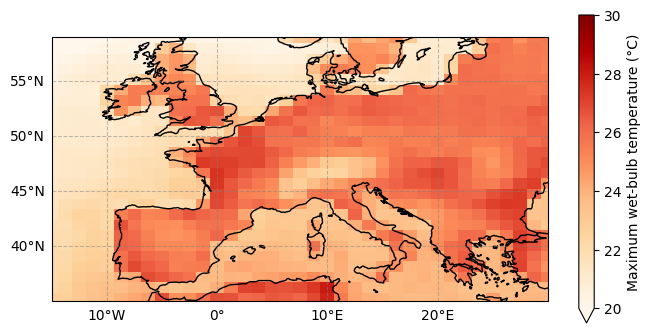

In [19]:
# Compute max wet-bulb temperature at each grid cell
max_T_WB = df_historic['T_WB'].max(dim=['member_id', 'time'])

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
max_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
#ax.set_title('Maximum Wet-Bulb Temperature (1970–1999)')

plt.savefig('../analysis/figures/historic/max_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

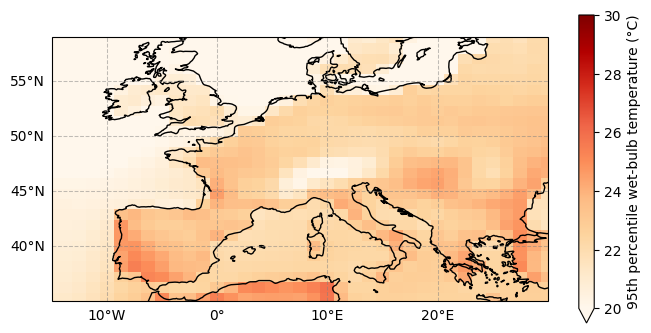

In [18]:
# Compute the 95th percentile wet-bulb temperature at each grid cell
p95_T_WB = df_historic['T_WB'].quantile(0.95, dim=['member_id', 'time'])


plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the 95th percentile T_WB
p95_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # or try 'inferno', 'plasma', 'cividis'
    cbar_kwargs={'label': '95th percentile wet-bulb temperature (°C)'},
    vmin=20, vmax=30  # adjust range to your data
)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title(None)

plt.savefig('../analysis/figures/historic/p95_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

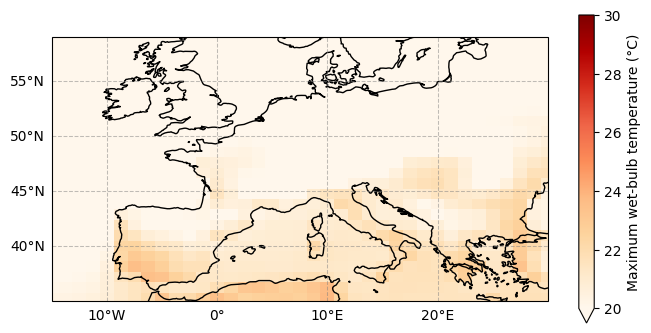

In [17]:
# Compute ensemble mean wet-bulb temperature at each grid cell
mean_T_WB = df_historic['T_WB'].mean(dim=['member_id', 'time'])

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
#ax.set_title('Wet-Bulb Temperature ensemble mean (1970–1999)')

plt.savefig('../analysis/figures/historic/ensemblemean_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

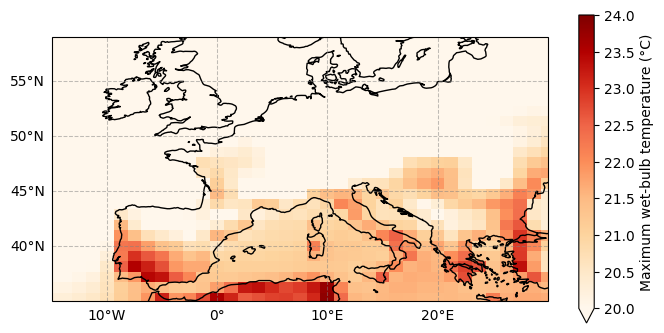

In [6]:
# Warmest memeber (r10i1281p1f1)
specific_member_T_WB = df_historic.sel(member_id='r10i1281p1f1')['T_WB']
# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=24)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/historic/mean_warmest_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')
plt.show()

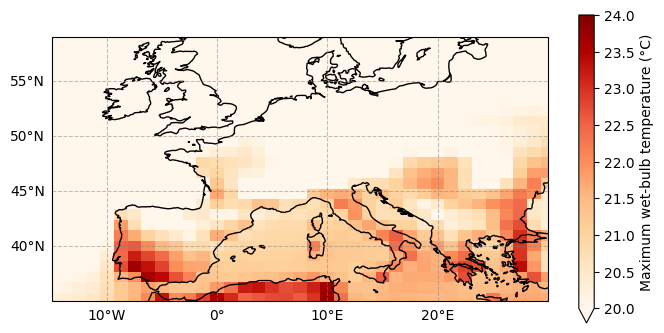

In [7]:
# coldest memeber (r9i1281p1f1)
specific_member_T_WB = df_historic.sel(member_id= 'r9i1281p1f1')['T_WB']

# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=24)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/historic/mean_coldest_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')
plt.show()

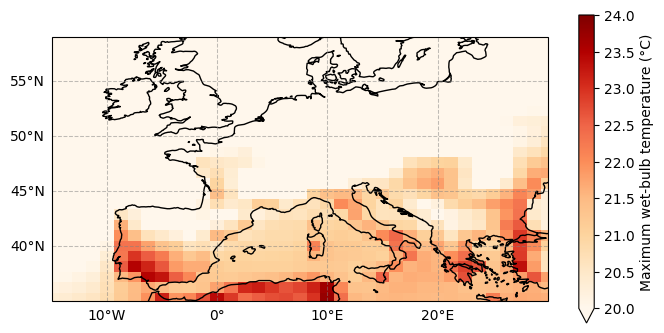

In [8]:
# Median memeber (r6i1281p1f1)
specific_member_T_WB = df_historic.sel(member_id= 'r6i1281p1f1')['T_WB']

# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=24)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)

plt.savefig('../analysis/figures/historic/mean_median_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')
plt.show()

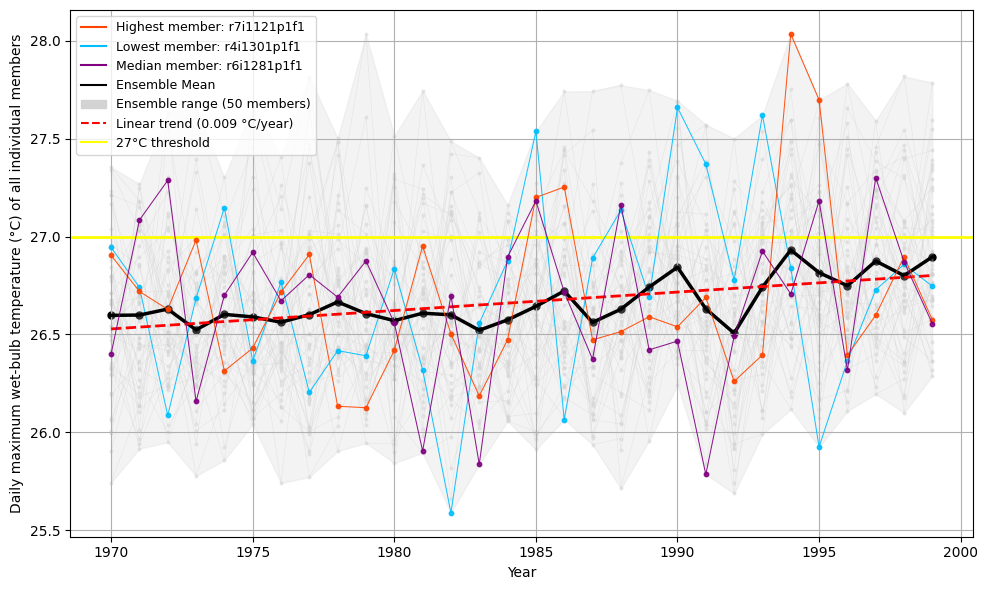

In [26]:
# Step 1: Extract the year from time and assign it as a new coordinate
years = df_historic['time'].dt.year
df_yearly = df_historic.assign_coords(year=("time", years.data))

# Step 2: Compute yearly max WBT for each member across space and time
TWB_max_per_year = df_yearly['T_WB'].max(dim=['lat', 'lon']).groupby('year').max(dim='time')

# Step 3: Ensemble statistics
mean_TWB = TWB_max_per_year.mean(dim='member_id')
min_TWB = TWB_max_per_year.min(dim='member_id')
max_TWB = TWB_max_per_year.max(dim='member_id')

# Linear regression on yearly ensemble mean
years = mean_TWB.year.values
slope, intercept, r_value, p_value, std_err = linregress(years, mean_TWB.values)
trend_line = intercept + slope * years

# Step 4: Identify warmest/coldest members (average across years)
member_means = TWB_max_per_year.mean(dim='year')
warmest_member = member_means.member_id[member_means.argmax(dim='member_id')].item()
coldest_member = member_means.member_id[member_means.argmin(dim='member_id')].item()

# Step 5: Identify members with absolute max/min values
flat_vals = TWB_max_per_year.stack(z=('year', 'member_id'))
max_member = flat_vals.member_id[flat_vals.argmax(dim='z')].item()
min_member = flat_vals.member_id[flat_vals.argmin(dim='z')].item()# Step 5: Identify members with absolute max/min values
flat_vals = TWB_max_per_year.stack(z=('year', 'member_id'))
max_member = flat_vals.member_id[flat_vals.argmax(dim='z')].item()
min_member = flat_vals.member_id[flat_vals.argmin(dim='z')].item()

# Extract values for each highlighted member
warmest_member_values = TWB_max_per_year.sel(member_id=warmest_member)
coldest_member_values = TWB_max_per_year.sel(member_id=coldest_member)
max_member_values = TWB_max_per_year.sel(member_id=max_member)
min_member_values = TWB_max_per_year.sel(member_id=min_member)

highlighted_member = "r6i1281p1f1"

plt.figure(figsize=(10, 6))
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)
# Track which labels have already been added to avoid duplicates
plotted_labels = set()

for member in TWB_max_per_year.member_id.values:
    data = TWB_max_per_year.sel(member_id=member)

    if member == highlighted_member:
        line_color = 'purple' 
        label = f'Highlighted Member ({highlighted_member})'
        zorder = 5  
    elif member == max_member:
        line_color = 'orangered'
        label = 'Absolute Max'
        zorder = 4
    elif member == min_member:
        line_color = 'deepskyblue'
        label = 'Absolute Min'
        zorder = 2
    else:
        line_color = 'lightgray'
        label = None
        zorder = 1

    # Only add label once
    plot_label = label if label and label not in plotted_labels else None
    if plot_label:
        plotted_labels.add(label)

    plt.plot(
        years,
        data,
        color=line_color,
        linewidth=0.75 if label else 0.5,
        alpha=0.9 if label else 0.4,
        zorder=zorder,
        label=plot_label
    )
    
    plt.scatter(
        years,
        data,
        color=line_color,
        s=10 if label else 4,
        alpha=0.9 if label else 0.4,
        zorder=zorder
    )

# Ensemble mean
plt.plot(years, mean_TWB, color='black', linewidth=2.5, label='Ensemble Mean')
plt.scatter(years, mean_TWB, color='black', s=25)

# Shaded ensemble range
plt.fill_between(years, min_TWB, max_TWB, color='lightgray', alpha=0.25)

# Trend line
plt.plot(years, trend_line, color='red', linestyle='--', linewidth=2)

# Custom legend (in specific order)
custom_lines = [
    Line2D([], [], color='orangered', lw=1.5, label=f"Highest member: {max_member}"),
    Line2D([], [], color='deepskyblue', lw=1.5, label=f"Lowest member: {min_member}"),
    Line2D([], [], color='purple', lw=1.5, label=f"Median member: {highlighted_member}"),  # Add highlighted member to legend
    Line2D([], [], color='black', lw=1.5, label='Ensemble Mean'),
    Patch(facecolor='lightgray', edgecolor='lightgray', label='Ensemble range (50 members)'),
    Line2D([], [], color='red', linestyle='--', lw=1.5, label=f'Linear trend ({slope:.3f} °C/year)'),
    Line2D([], [], color='yellow', lw=1.5, label='27°C threshold'),
]

plt.legend(handles=custom_lines, loc='upper left', fontsize=9)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Daily maximum wet-bulb temperature (°C) of all individual members")
plt.title(None)
plt.grid(True)
plt.tight_layout()

plt.savefig('../analysis/figures/historic/ensemble_members_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

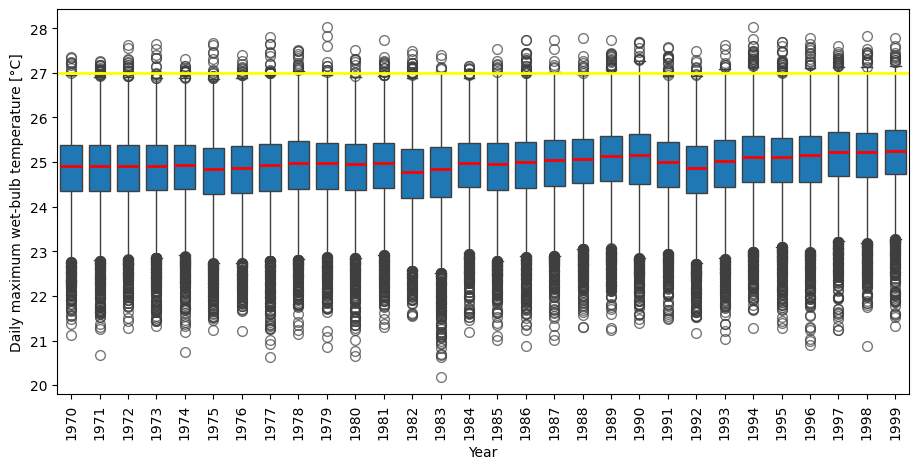

In [9]:
# Load dataset (assuming you've already loaded it)
df = df_historic["T_WB"].max(dim=["lat", "lon"])
df["year"] = df["time"].dt.year
df = df.to_dataframe().reset_index()


plt.figure(figsize=(11, 5))
sns.boxplot(x="year", y="T_WB", 
            data=df,
            whis= 1.5,
            width=0.75,
            fliersize=2,
            saturation=20,
            medianprops={"color": "r", "linewidth": 2},
            flierprops={"marker": "o", "color": "blue", "markersize": 7, "alpha": 0.7}
           )
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)  # Horizontal line at y=27
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Daily maximum wet-bulb temperature [°C]")

plt.savefig('../analysis/figures/historic/daily_max_member_spread_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

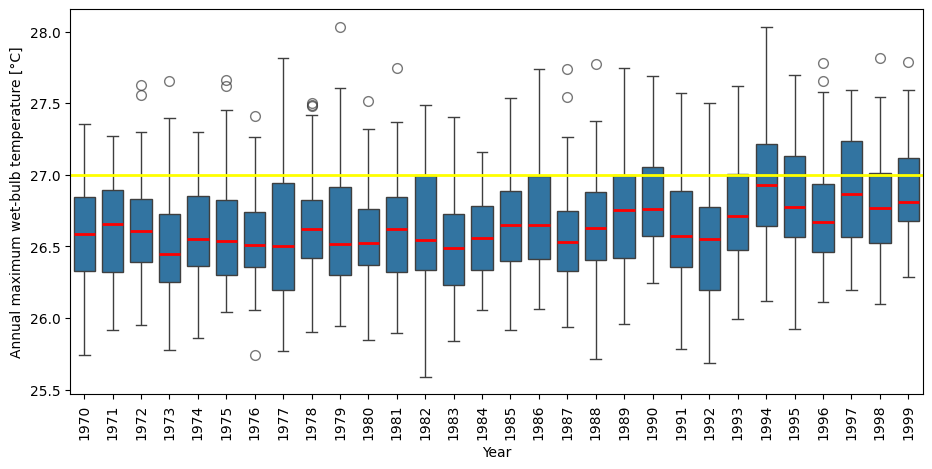

In [10]:
# Load dataset (assuming you've already loaded it)
df = df_historic["T_WB"].max(dim=["lat", "lon"])
df["year"] = df["time"].dt.year
df = df.to_dataframe().reset_index()
# Assuming your dataset is already loaded as df

# Step 1: Calculate the annual maximum T_WB for each member_id
df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' is a datetime object
df_max_annual = df.groupby(['year', 'member_id'])['T_WB'].max().reset_index()

# Step 2: Create the boxplot for annual maximum T_WB by year
plt.figure(figsize=(11, 5))
sns.boxplot(x='year', y='T_WB', data=df_max_annual,
            whis=1.5,  # Whisker length
            width=0.75,  # Width of the boxes
            fliersize=5,  # Outlier size
            saturation=0.75,  # Transparency
            medianprops={"color": "r", "linewidth": 2},
            flierprops={"marker": "o", "color": "blue", "markersize": 7, "alpha": 0.7})  # Outlier customization

# Add a horizontal line (if you want) at a specific T_WB value, say 27
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)

# Final touches
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Annual maximum wet-bulb temperature [°C]")

plt.savefig('../analysis/figures/historic/annual_max_member_spread_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

# Future

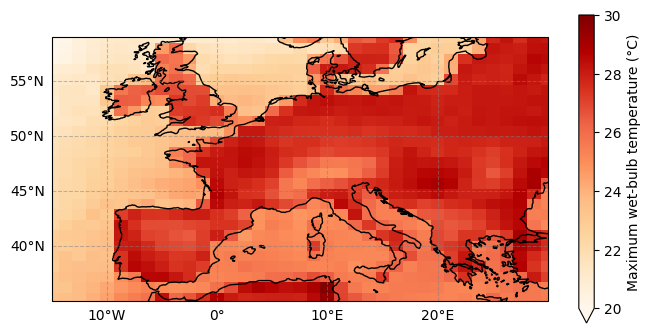

In [27]:
# Compute max wet-bulb temperature at each grid cell
max_T_WB = df_future['T_WB'].max(dim=['member_id', 'time'])

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
max_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
#ax.set_title('Maximum Wet-Bulb Temperature (1970–1999)')

plt.savefig('../analysis/figures/future/max_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

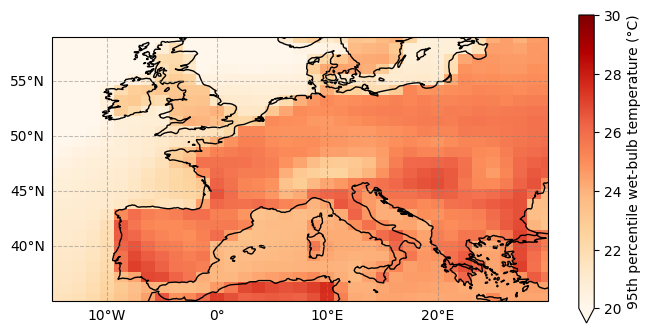

In [28]:
# Compute the 95th percentile wet-bulb temperature at each grid cell
p95_T_WB = df_future['T_WB'].quantile(0.95, dim=['member_id', 'time'])


plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the 95th percentile T_WB
p95_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # or try 'inferno', 'plasma', 'cividis'
    cbar_kwargs={'label': '95th percentile wet-bulb temperature (°C)'},
    vmin=20, vmax=30  # adjust range to your data
)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title(None)

plt.savefig('../analysis/figures/future/p95_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

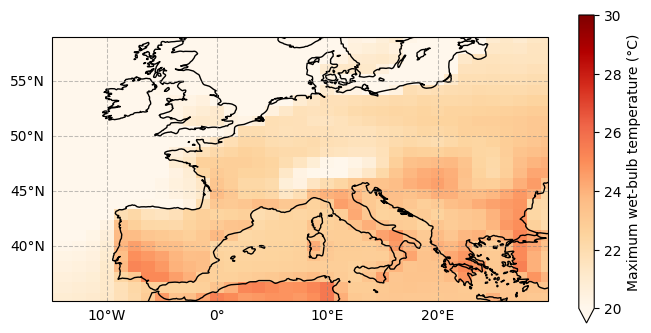

In [29]:
# Compute ensemble mean wet-bulb temperature at each grid cell
mean_T_WB = df_future['T_WB'].mean(dim=['member_id', 'time'])

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
#ax.set_title('Wet-Bulb Temperature ensemble mean (1970–1999)')

plt.savefig('../analysis/figures/future/ensemblemean_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

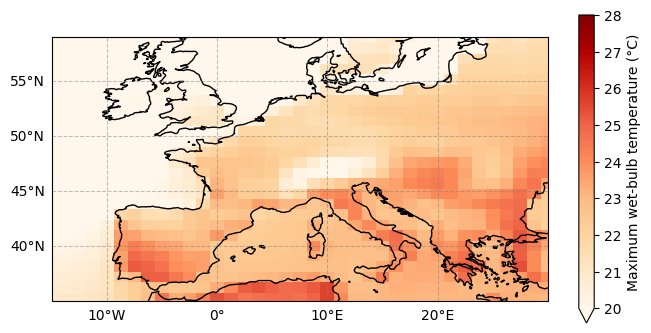

In [30]:
# Warmest memeber (r10i1281p1f1)
specific_member_T_WB = df_future.sel(member_id='r10i1281p1f1')['T_WB']
# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=28)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/future/mean_warmest_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')
plt.show()

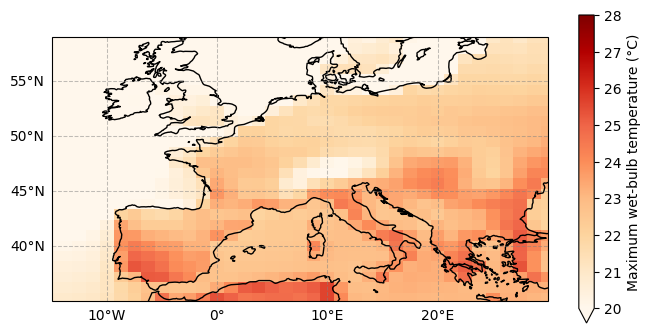

In [31]:
# coldest memeber (r9i1281p1f1)
specific_member_T_WB = df_future.sel(member_id= 'r9i1281p1f1')['T_WB']
# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=28)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/future/mean_coldest_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')
plt.show()

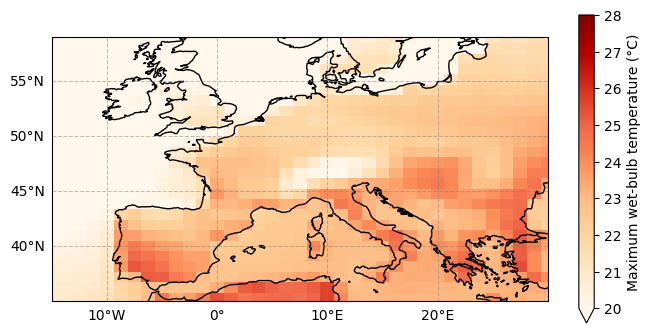

In [32]:
# Median memeber (r6i1281p1f1)
specific_member_T_WB = df_future.sel(member_id= 'r6i1281p1f1')['T_WB']

# Calculate the mean over the time dimension (mean over 30 years for that member)
mean_member_T_WB = specific_member_T_WB.mean(dim='time')

# Plot the mean over time for this specific ensemble member
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

mean_member_T_WB.plot(
    ax=ax,
    cmap='OrRd',
    cbar_kwargs={'label': 'Maximum wet-bulb temperature (°C)'},
    vmin=20, vmax=28)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)

plt.savefig('../analysis/figures/future/mean_median_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')
plt.show()

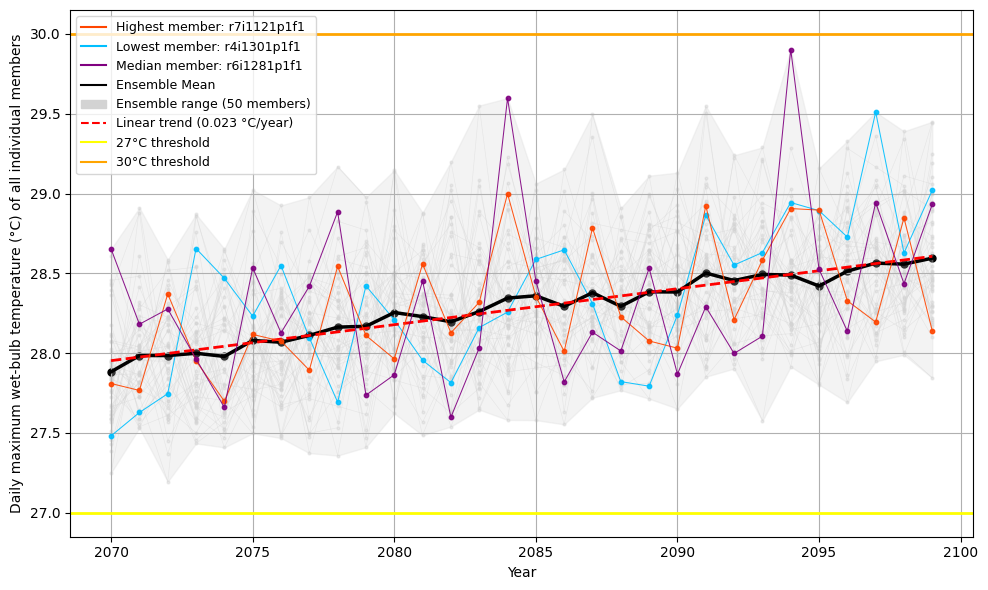

In [30]:
# Step 1: Extract the year from time and assign it as a new coordinate
years = df_future['time'].dt.year
df_yearly = df_future.assign_coords(year=("time", years.data))

# Step 2: Compute yearly max WBT for each member across space and time
TWB_max_per_year = df_yearly['T_WB'].max(dim=['lat', 'lon']).groupby('year').max(dim='time')

# Step 3: Ensemble statistics
mean_TWB = TWB_max_per_year.mean(dim='member_id')
min_TWB = TWB_max_per_year.min(dim='member_id')
max_TWB = TWB_max_per_year.max(dim='member_id')

# Linear regression on yearly ensemble mean
years = mean_TWB.year.values
slope, intercept, r_value, p_value, std_err = linregress(years, mean_TWB.values)
trend_line = intercept + slope * years


highlighted_member = "r6i1281p1f1"
min_member = "r4i1301p1f1"
max_member = "r7i1121p1f1"

plt.figure(figsize=(10, 6))
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)
plt.axhline(y=30, color='orange', linestyle='-', linewidth=2)

# Track which labels have already been added to avoid duplicates
plotted_labels = set()

for member in TWB_max_per_year.member_id.values:
    data = TWB_max_per_year.sel(member_id=member)

    if member == highlighted_member:
        line_color = 'purple' 
        label = f'Highlighted Member ({highlighted_member})'
        zorder = 5  
    elif member == max_member:
        line_color = 'orangered'
        label = 'Absolute Max'
        zorder = 4
    elif member == min_member:
        line_color = 'deepskyblue'
        label = 'Absolute Min'
        zorder = 2
    else:
        line_color = 'lightgray'
        label = None
        zorder = 1

    # Only add label once
    plot_label = label if label and label not in plotted_labels else None
    if plot_label:
        plotted_labels.add(label)

    plt.plot(
        years,
        data,
        color=line_color,
        linewidth=0.75 if label else 0.5,
        alpha=0.9 if label else 0.4,
        zorder=zorder,
        label=plot_label
    )
    
    plt.scatter(
        years,
        data,
        color=line_color,
        s=10 if label else 4,
        alpha=0.9 if label else 0.4,
        zorder=zorder
    )

# Ensemble mean
plt.plot(years, mean_TWB, color='black', linewidth=2.5, label='Ensemble Mean')
plt.scatter(years, mean_TWB, color='black', s=25)

# Shaded ensemble range
plt.fill_between(years, min_TWB, max_TWB, color='lightgray', alpha=0.25)

# Trend line
plt.plot(years, trend_line, color='red', linestyle='--', linewidth=2)

# Custom legend (in specific order)
custom_lines = [
    Line2D([], [], color='orangered', lw=1.5, label=f"Highest member: {max_member}"),
    Line2D([], [], color='deepskyblue', lw=1.5, label=f"Lowest member: {min_member}"),
    Line2D([], [], color='purple', lw=1.5, label=f"Median member: {highlighted_member}"),  # Add highlighted member to legend
    Line2D([], [], color='black', lw=1.5, label='Ensemble Mean'),
    Patch(facecolor='lightgray', edgecolor='lightgray', label='Ensemble range (50 members)'),
    Line2D([], [], color='red', linestyle='--', lw=1.5, label=f'Linear trend ({slope:.3f} °C/year)'),
    Line2D([], [], color='yellow', lw=1.5, label='27°C threshold'),
    Line2D([], [], color='orange', lw=1.5, label='30°C threshold'),
]

plt.legend(handles=custom_lines, loc='upper left', fontsize=9)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Daily maximum wet-bulb temperature (°C) of all individual members")
plt.title(None)
plt.grid(True)
plt.tight_layout()

plt.savefig('../analysis/figures/future/ensemble_members_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

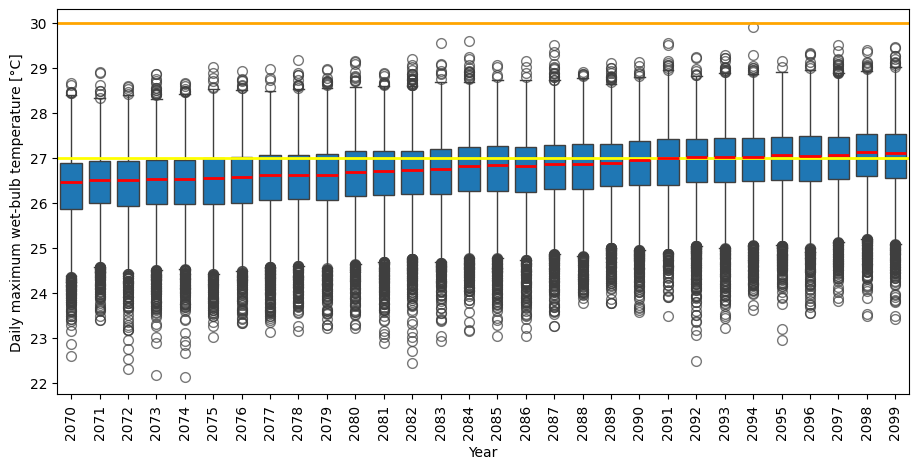

In [11]:
# Load dataset (assuming you've already loaded it)
df = df_future["T_WB"].max(dim=["lat", "lon"])
df["year"] = df["time"].dt.year
df = df.to_dataframe().reset_index()


plt.figure(figsize=(11, 5))
sns.boxplot(x="year", y="T_WB", 
            data=df,
            whis= 1.5,
            width=0.75,
            fliersize=2,
            saturation=20,
            medianprops={"color": "r", "linewidth": 2},
            flierprops={"marker": "o", "color": "blue", "markersize": 7, "alpha": 0.7}
           )
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)  # Horizontal line at y=27
plt.axhline(y=30, color='orange', linestyle='-', linewidth=2)  # Horizontal line at y=27
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Daily maximum wet-bulb temperature [°C]")

plt.savefig('../analysis/figures/future/daily_max_member_spread_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

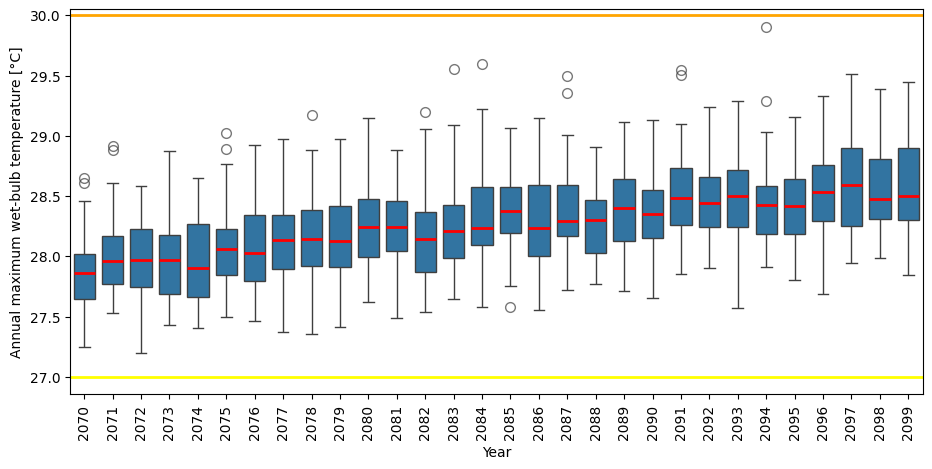

In [12]:
# Load dataset (assuming you've already loaded it)
df = df_future["T_WB"].max(dim=["lat", "lon"])
df["year"] = df["time"].dt.year
df = df.to_dataframe().reset_index()
# Assuming your dataset is already loaded as df

# Step 1: Calculate the annual maximum T_WB for each member_id
df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' is a datetime object
df_max_annual = df.groupby(['year', 'member_id'])['T_WB'].max().reset_index()

# Step 2: Create the boxplot for annual maximum T_WB by year
plt.figure(figsize=(11, 5))
sns.boxplot(x='year', y='T_WB', data=df_max_annual,
            whis=1.5,  # Whisker length
            width=0.75,  # Width of the boxes
            fliersize=5,  # Outlier size
            saturation=0.75,  # Transparency
            medianprops={"color": "r", "linewidth": 2},
            flierprops={"marker": "o", "color": "blue", "markersize": 7, "alpha": 0.7})  # Outlier customization

# Add a horizontal line (if you want) at a specific T_WB value, say 27
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)
plt.axhline(y=30, color='orange', linestyle='-', linewidth=2)

# Final touches
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Annual maximum wet-bulb temperature [°C]")

plt.savefig('../analysis/figures/future/annual_max_member_spread_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

# Anoamlies

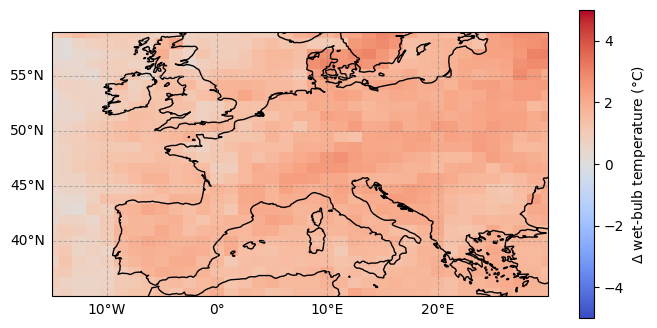

In [37]:
max_T_WB_h = df_historic['T_WB'].max(dim=['member_id', 'time'])
max_T_WB_f = df_future['T_WB'].max(dim=['member_id', 'time'])
max_T_WB = max_T_WB_f - max_T_WB_h

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
max_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/anomalies/max_T_WB.png', dpi=1000, bbox_inches='tight')

plt.show()

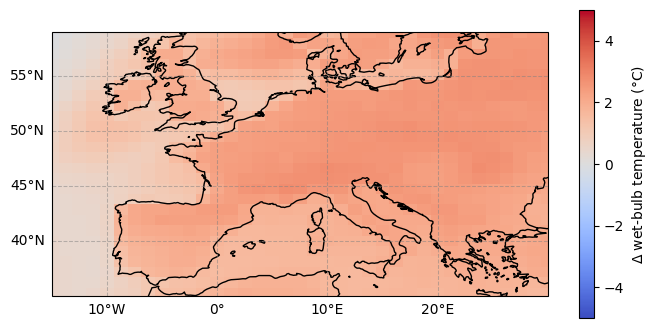

In [38]:
p95_T_WB_h = df_historic['T_WB'].quantile(0.95, dim=['member_id', 'time'])
p95_T_WB_f = df_future['T_WB'].quantile(0.95, dim=['member_id', 'time'])

p95_T_WB = p95_T_WB_f - p95_T_WB_h
# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
p95_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)

plt.savefig('../analysis/figures/anomalies/p95_TWB.png', dpi=1000, bbox_inches='tight')

plt.show()

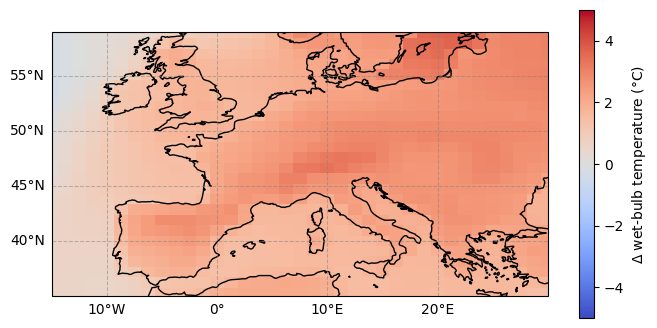

In [39]:
mean_T_WB_h = df_historic['T_WB'].mean(dim=['member_id', 'time'])
mean_T_WB_f = df_future['T_WB'].mean(dim=['member_id', 'time'])

mean_T_WB = mean_T_WB_f - mean_T_WB_h

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/anomalies/mean_T_WB.png', dpi=1000, bbox_inches='tight')

plt.show()

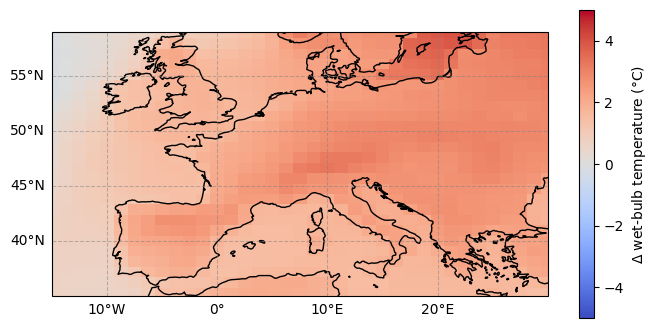

In [40]:
specific_member_T_WB_h = df_historic.sel(member_id='r10i1281p1f1')['T_WB']
mean_member_T_WB_h = specific_member_T_WB_h.mean(dim='time')

specific_member_T_WB_f = df_future.sel(member_id='r10i1281p1f1')['T_WB']
mean_member_T_WB_f = specific_member_T_WB_f.mean(dim='time')

mean_member_T_WB = mean_member_T_WB_f - mean_member_T_WB_h

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_member_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/anomalies/mean_member_T_WB.png', dpi=1000, bbox_inches='tight')

plt.show()

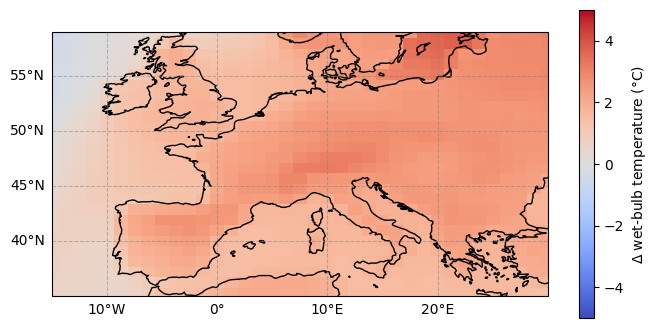

In [41]:
specific_member_T_WB_h = df_historic.sel(member_id='r9i1281p1f1')['T_WB']
specific_member_T_WB_h = specific_member_T_WB_h.mean(dim='time')

specific_member_T_WB_f = df_future.sel(member_id='r9i1281p1f1')['T_WB']
specific_member_T_WB_f = specific_member_T_WB_f.mean(dim='time')

specific_member_T_WB = specific_member_T_WB_f - specific_member_T_WB_h

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
specific_member_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/anomalies/r9i1281p1f1_specific_member_T_WB.png', dpi=1000, bbox_inches='tight')

plt.show()

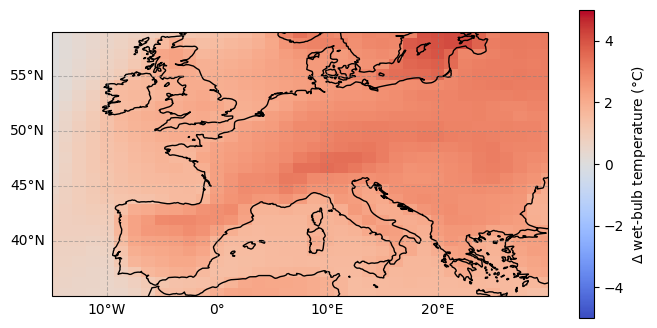

In [42]:
specific_member_T_WB_h = df_historic.sel(member_id='r6i1281p1f1')['T_WB']
specific_member_T_WB_h = specific_member_T_WB_h.mean(dim='time')

specific_member_T_WB_f = df_future.sel(member_id='r6i1281p1f1')['T_WB']
specific_member_T_WB_f = specific_member_T_WB_f.mean(dim='time')

specific_member_T_WB = specific_member_T_WB_f - specific_member_T_WB_h

# Plot the maximum T_WB
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
specific_member_T_WB.plot(
    ax=ax,
    cmap='coolwarm',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': '$\Delta$ wet-bulb temperature (°C)'},
    vmin=-5, vmax=5)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.set_title(None)


plt.savefig('../analysis/figures/anomalies/r6i1281p1f1_specific_member_T_WB.png', dpi=1000, bbox_inches='tight')

plt.show()